In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=4)
                for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
class_names

['AMD', 'CNV', 'CSR', 'DME', 'DR', 'DRUSEN', 'MH', 'NORMAL']

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
vgg16

D:\PycharmProjects\TER\TER\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\PycharmProjects\TER\TER\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# change the last layer to 8 classes
vgg16.classifier[6].out_features = 8
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
# freeze all the layers
for param in vgg16.features.parameters():
    param.requires_grad = False

In [7]:
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [11]:
def train_model(model,train_data):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_data:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / dataset_sizes['train']
    epoch_acc = running_corrects.double() / dataset_sizes['train']
    return epoch_loss, epoch_acc

In [12]:
def val(model,val_data):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in val_data:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / dataset_sizes['val']
    epoch_acc = running_corrects.double() / dataset_sizes['val']
    return epoch_loss, epoch_acc

In [14]:
import time

# training function
train_loss_vgg , train_accuracy_vgg = [], []
val_loss_vgg , val_accuracy_vgg = [], []
epoch_times = []
start = time.time()
num_epoch = 6
for epoch in range(num_epoch):
    epoch_start = time.time()
    print('Epoch {}/{}'.format(epoch, num_epoch - 1))
    print('-' * 10)
    train_epoch_loss , train_epoch_acc = train_model(vgg16,dataloaders['train'])
    val_epoch_loss , val_epoch_acc = val(vgg16,dataloaders['val'])
    train_loss_vgg.append(train_epoch_loss)
    train_accuracy_vgg.append(train_epoch_acc)
    val_loss_vgg.append(val_epoch_loss)
    val_accuracy_vgg.append(val_epoch_acc)
    epoch_end = time.time()
    epoch_time = epoch_end - epoch_start
    epoch_times.append(epoch_time)
    print('Training Loss: {:.4f} Acc: {:.4f}'.format(train_epoch_loss, train_epoch_acc))
    print('Validation Loss: {:.4f} Acc: {:.4f}'.format(val_epoch_loss, val_epoch_acc))
    print('Epoch time: {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))
    print()
end = time.time()
total_time = end - start
print('Training complete in {:.0f}m {:.0f}s'.format(total_time // 60, total_time % 60))
print('Average epoch time: {:.0f}m {:.0f}s'.format(np.mean(epoch_times) // 60, np.mean(epoch_times) % 60))

Epoch 0/5
----------
Training Loss: 0.5926 Acc: 0.7603
Validation Loss: 0.3111 Acc: 0.8925
Epoch time: 9m 54s

Epoch 1/5
----------
Training Loss: 0.5512 Acc: 0.7792
Validation Loss: 0.3138 Acc: 0.8843
Epoch time: 9m 53s

Epoch 2/5
----------
Training Loss: 0.5249 Acc: 0.7876
Validation Loss: 0.3069 Acc: 0.8779
Epoch time: 10m 16s

Epoch 3/5
----------
Training Loss: 0.5097 Acc: 0.7938
Validation Loss: 0.3065 Acc: 0.8896
Epoch time: 10m 1s

Epoch 4/5
----------
Training Loss: 0.4913 Acc: 0.8030
Validation Loss: 0.2462 Acc: 0.9136
Epoch time: 10m 57s

Epoch 5/5
----------
Training Loss: 0.4813 Acc: 0.8054
Validation Loss: 0.2819 Acc: 0.8854
Epoch time: 11m 10s

Training complete in 62m 11s
Average epoch time: 10m 22s


In [15]:
#save the model
torch.save(vgg16.state_dict(), 'vgg16.pth')

In [16]:
%store train_loss_vgg
%store train_accuracy_vgg
%store val_loss_vgg
%store val_accuracy_vgg
%store epoch_times
%store total_time

Stored 'train_loss_vgg' (list)
Stored 'train_accuracy_vgg' (list)
Stored 'val_loss_vgg' (list)
Stored 'val_accuracy_vgg' (list)
Stored 'epoch_times' (list)
Stored 'total_time' (float)


In [20]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

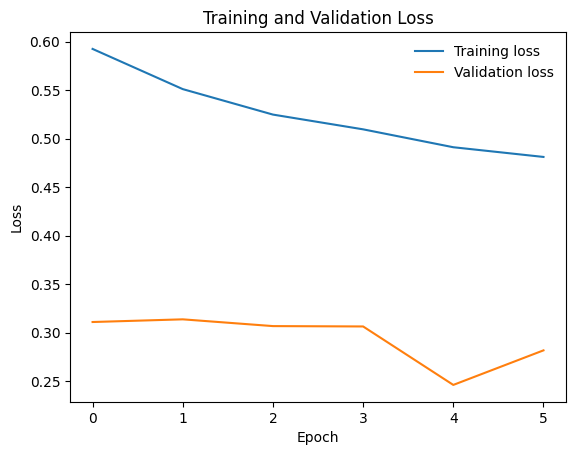

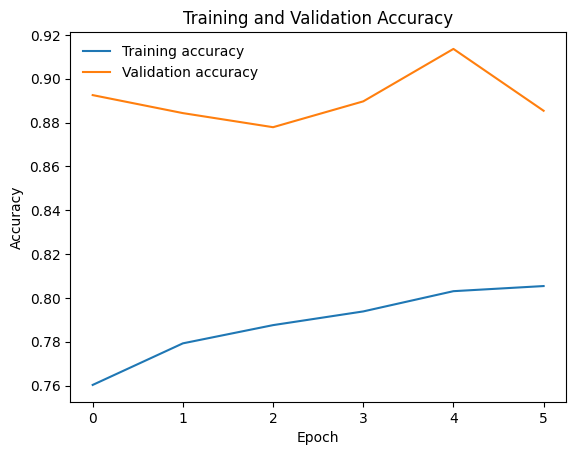

In [21]:
# plot the training and validation loss
plt.plot(to_numpy(torch.Tensor(train_loss_vgg)), label='Training loss')
plt.plot(to_numpy(torch.Tensor(val_loss_vgg)), label='Validation loss')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.show()

# plot the training and validation accuracy
plt.plot(to_numpy(torch.Tensor(train_accuracy_vgg)), label='Training accuracy')
plt.plot(to_numpy(torch.Tensor(val_accuracy_vgg)), label='Validation accuracy')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

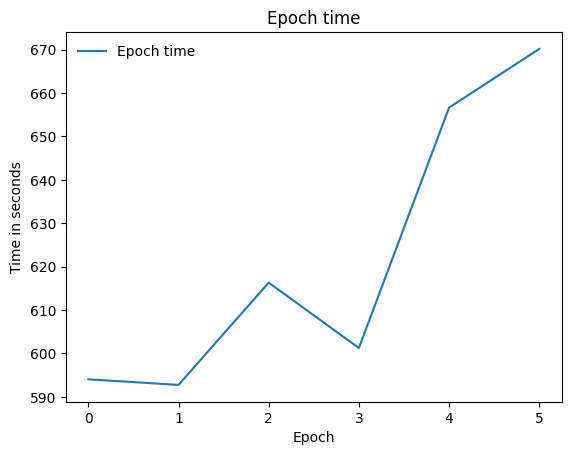

In [23]:
#plot time
plt.plot(epoch_times, label='Epoch time')
plt.legend(frameon=False)
plt.xlabel('Epoch')
plt.ylabel('Time in seconds')
plt.title('Epoch time')
plt.show()

In [24]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

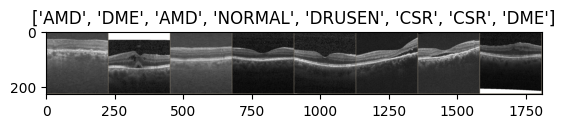

GroundTruth:    AMD   DME   AMD NORMAL DRUSEN   CSR   CSR   DME


In [25]:
# Get a random subset of the images
inputs, classes = next(iter(dataloaders['val']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])
print('GroundTruth: ', ' '.join('%5s' % class_names[classes[j]] for j in range(8)))

In [26]:
#display predictions
outputs = vgg16(inputs.to(device))
_, preds = torch.max(outputs, 1)

# Print predictions
print('Predicted: ', ' '.join('%5s' % class_names[preds[j]]
                              for j in range(8)))

Predicted:    AMD   DME   AMD NORMAL NORMAL   CSR   CSR NORMAL


In [31]:
#accuracy on the test set
vgg16.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_vgg = 100 * correct / total

print('Accuracy of the network on val images: %d %%' % accuracy_vgg)

Accuracy of the network on val images: 88 %


In [32]:
%store accuracy_vgg

Stored 'accuracy_vgg' (float)


In [37]:
# Loop over the accuracies for the 8 labels and print them
class_correct = list(0. for i in range(8))
class_total = list(0. for i in range(8))
#create a dictionary with the labels and the corresponding class names
class_names_dict = {0: class_names[0], 1: class_names[1], 2: class_names[2], 3: class_names[3], 4: class_names[4], 5: class_names[5], 6: class_names[6], 7: class_names[7]}


with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(8):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

#add the accuracies to the dictionary
for i in range(8):
    class_names_dict[i] = class_names_dict[i], 100 * class_correct[i] / class_total[i]

In [38]:
class_names_dict

{0: ('AMD', 100.0),
 1: ('CNV', 90.0),
 2: ('CSR', 100.0),
 3: ('DME', 70.28571428571429),
 4: ('DR', 95.71428571428571),
 5: ('DRUSEN', 56.285714285714285),
 6: ('MH', 98.57142857142857),
 7: ('NORMAL', 97.42857142857143)}

In [39]:
%store class_names_dict

Stored 'class_names_dict' (dict)
